In [13]:
import pandas as pd
import numpy as np

# ML & NLP
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ================================
# LOAD DATASET
# ================================
file_path = "/kaggle/input/ashuganj-power-plant-dataset-tahia/Trip and shutdown register for 400 MW CCPP East.xlsx"
df = pd.read_excel(file_path)

print("Raw dataset preview:")
print(df.head())


Raw dataset preview:
  Ashuganj Power Station Company Limited\n               400MW CCPP East                   Updated: 03.11.2022\n  \
0                                             SL NO.                                                               
1                                                NaN                                                               
2                                                  1                                                               
3                                                  2                                                               
4                                                  3                                                               

  Unnamed: 1   Unnamed: 2  Unnamed: 3        Unnamed: 4  \
0       Date  Time Out/In  Unit GT/ST   Start/ S/D/Trip   
1        NaN          NaN         NaN               NaN   
2   29.05.22     13:22:00          GT  First time fired   
3   30.05.22     10:39:00          GT    2nd t

In [14]:
# STEP 1 — FIX HEADER ROW
# ================================
df.columns = df.iloc[0]         # First row contains column names
df = df[1:]                     # Remove first row
df = df.reset_index(drop=True)

# Rename properly
df = df.rename(columns={
    "Date": "Date",
    "Time Out/In": "Time",
    "Unit GT/ST": "Unit",
    "Start/ S/D/Trip": "Event",
    "Cause": "Cause",
    "Maintenance Work done": "Maintenance"
})

# Keep only the needed columns
df = df[["Date", "Time", "Unit", "Event", "Cause", "Maintenance"]]

print("\nCleaned column names:")
print(df.head())



Cleaned column names:
0      Date      Time Unit             Event                     Cause  \
0       NaN       NaN  NaN               NaN                       NaN   
1  29.05.22  13:22:00   GT  First time fired  GT speed up to 33.178 hz   
2  30.05.22  10:39:00   GT    2nd time fired      GT speed up to 50 hz   
3  30.05.22  11:09:00   GT          shutdown        Press Emergency PB   
4  18.06.22  10:00:00  GT   Speed up to 50hz  Excitation test going on   

0 Maintenance  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN  


In [15]:
# ================================
# STEP 2 — CLEAN DATE & TIME
# ================================

# Remove rows where Date doesn't contain numbers
df = df[df["Date"].astype(str).str.contains(r"\d", na=False)]

# Clean multiple date formats
df["Date"] = (
    df["Date"].astype(str)
               .str.replace(" ", "")
               .str.replace("/", "-")
               .str.replace(".", "-")
)

# Try parsing multiple common power plant log formats
def parse_date(x):
    for fmt in ("%d-%m-%y", "%d-%m-%Y", "%Y-%m-%d"):
        try:
            return pd.to_datetime(x, format=fmt)
        except:
            pass
            return pd.to_datetime("NaT")

df["Date"] = df["Date"].apply(parse_date)

# Parse Time safely
df["Time"] = pd.to_datetime(df["Time"], errors="coerce").dt.time

df = df.dropna(subset=["Event"])  # Keep only valid events
df = df.reset_index(drop=True)

# ================================
# STEP 3 — CLEAN EVENT NAMES
# ================================
def clean_event(e):
    e = str(e).lower()
    if "trip" in e:
        return "Trip"
    elif "shut" in e or "s/d" in e or "sd" in e:
        return "Shutdown"
    elif "start" in e or "fire" in e:
        return "Start"
    else:
        return "Other"

df["Event_Clean"] = df["Event"].apply(clean_event)
# ================================
# STEP 4 — FEATURE ENGINEERING
# ================================
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day
df["Weekday"] = df["Date"].dt.weekday
df["Cause"] = df["Cause"].fillna("Unknown")



In [16]:

# ================================
# STEP 5 — ENCODE TARGET
# ================================
y = df["Event_Clean"]

le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("\nLabel Mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

# ================================
# STEP 6 — NLP TEXT FEATURES
# ================================
text_data = df["Cause"]

X_train, X_test, y_train, y_test = train_test_split(
    text_data, y_encoded, test_size=0.2, random_state=42
)



# TF-IDF + Naive Bayes Pipeline
model = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("clf", MultinomialNB())
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)



Label Mapping: {'Other': 0, 'Shutdown': 1, 'Start': 2, 'Trip': 3}



=== Classification Report ===

              precision    recall  f1-score   support

       Other       0.71      0.92      0.80        13
    Shutdown       0.67      0.75      0.71         8
        Trip       1.00      0.44      0.62         9

    accuracy                           0.73        30
   macro avg       0.79      0.71      0.71        30
weighted avg       0.78      0.73      0.72        30



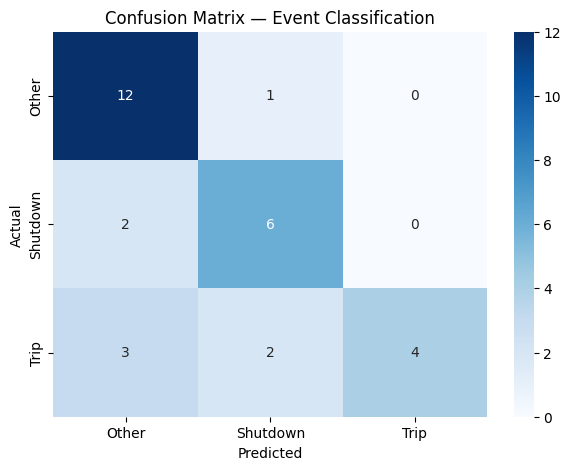

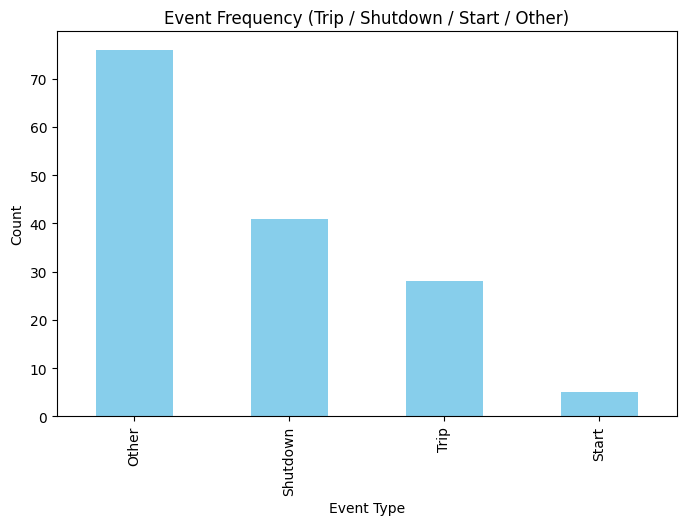

In [17]:

# STEP 7 — EVALUATION
print("\n=== Classification Report ===\n")

unique_labels = np.unique(y_test)

print(classification_report(
    y_test,
    y_pred,
    labels=unique_labels,
    target_names=le.inverse_transform(unique_labels)
))

cm = confusion_matrix(y_test, y_pred, labels=unique_labels)


plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, cmap="Blues",
            xticklabels=le.inverse_transform(unique_labels),
            yticklabels=le.inverse_transform(unique_labels))
plt.title("Confusion Matrix — Event Classification")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# ================================
# STEP 8 — VISUALIZATION SUMMARY
# ================================
plt.figure(figsize=(8,5))
df["Event_Clean"].value_counts().plot(kind="bar", color="skyblue")
plt.title("Event Frequency (Trip / Shutdown / Start / Other)")
plt.xlabel("Event Type")
plt.ylabel("Count")
plt.show()